In [7]:
from collections import deque
import random
from stockfish import Stockfish
import chess
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.compat.v1.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from IPython.display import display, HTML
import chess.svg
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tqdm import tqdm
from tensorflow.keras.models import Model
import chess.pgn
import numpy as np
from tensorflow.keras.models import load_model

In [8]:
def load_pgn_data(pgn_file_path):
    print("Loading PGN data from {}...",pgn_file_path)
    pgn_data = []
    with open(pgn_file_path) as pgn:
        while True:
            game = chess.pgn.read_game(pgn)
            if game is None:
                break
            board = game.board()
            for move in game.mainline_moves():
                input_array = board_to_input_array(board)
                output_array = move_to_output_array(move, board.legal_moves)
                pgn_data.append((input_array, output_array))
                board.push(move)
    return pgn_data


def board_to_input_array(board):
    board_array = np.zeros((8, 8, 12), dtype=np.uint8)
    piece_mapping = {'r': 0, 'n': 1, 'b': 2, 'q': 3, 'k': 4, 'p': 5, 'R': 6, 'N': 7, 'B': 8, 'Q': 9, 'K': 10, 'P': 11}
    #normalize piece values

    
    for square, piece in board.piece_map().items():
        piece_type = piece_mapping[piece.symbol()]
        color = int(piece.color)
        board_array[square // 8, square % 8, piece_type] = color + 1  # Use 0 for empty squares

    return board_array


def state_to_index(board):
    board_array = np.array(board_to_input_array(board))
    return hash(board_array.tostring()) % state_space_size[0]



def choose_action(board,model):
    if np.random.rand() < exploration_prob:
        return np.random.choice(list(board.legal_moves))
    else:
        state_index = state_to_index(board)
        legal_moves_list = list(board.legal_moves)
        if not legal_moves_list:
            return chess.Move.null()
        q_values = model.predict(np.array([board_to_input_array(board)]))[0]
        best_move_index = np.argmax(q_values)
        best_move_uci = legal_moves_list[min(best_move_index, len(legal_moves_list)-1)].uci()
        return chess.Move.from_uci(best_move_uci)
    
# Function to convert a move into an output array
def move_to_output_array(move, legal_moves):
    output_array = np.zeros(action_space_size)
    move_index = list(legal_moves).index(move)
    output_array[move_index] = 1
    return output_array

CNN Version

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Game: 0
1/1 [==============================] - 0s 28ms/step


/var/folders/wh/6vs39mgs1910xc7nplcv5b000000gn/T/ipykernel_3365/1499594528.py:34: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return hash(board_array.tostring()) % state_space_size[0]


1/1 [==============================] - 0s 9ms/step


Training:  10%|█         | 1/10 [00:01<00:16,  1.79s/it]

Total Reward for Game 0: -104.10000000000001
Game Outcome: 0-1
Game Length: 11
Game: 1
1/1 [==============================] - 0s 10ms/step


Training:  20%|██        | 2/10 [00:03<00:12,  1.59s/it]

Total Reward for Game 1: -102.9
Game Outcome: 0-1
Game Length: 10
Game: 2
1/1 [==============================] - 0s 9ms/step


Training:  30%|███       | 3/10 [00:04<00:10,  1.46s/it]

Total Reward for Game 2: -103.1
Game Outcome: 0-1
Game Length: 10
Game: 3
1/1 [==============================] - 0s 9ms/step


Training:  40%|████      | 4/10 [00:06<00:08,  1.49s/it]

Total Reward for Game 3: -104.30000000000001
Game Outcome: 0-1
Game Length: 14
Game: 4
1/1 [==============================] - 0s 9ms/step


Training:  50%|█████     | 5/10 [00:07<00:07,  1.52s/it]

Total Reward for Game 4: -104.30000000000001
Game Outcome: 0-1
Game Length: 14
Game: 5
1/1 [==============================] - 0s 8ms/step


Training:  60%|██████    | 6/10 [00:09<00:06,  1.58s/it]

Total Reward for Game 5: -102.9
Game Outcome: 0-1
Game Length: 14
Game: 6
1/1 [==============================] - 0s 9ms/step


Training:  70%|███████   | 7/10 [00:11<00:05,  1.78s/it]

Total Reward for Game 6: -103.80000000000001
Game Outcome: 0-1
Game Length: 15
Game: 7
1/1 [==============================] - 0s 9ms/step


Training:  80%|████████  | 8/10 [00:13<00:03,  1.70s/it]

Total Reward for Game 7: -104.30000000000001
Game Outcome: 0-1
Game Length: 14
Game: 8
1/1 [==============================] - 0s 9ms/step


Training:  90%|█████████ | 9/10 [00:14<00:01,  1.66s/it]

Total Reward for Game 8: -104.30000000000001
Game Outcome: 0-1
Game Length: 14
Game: 9
1/1 [==============================] - 0s 9ms/step


Training: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]

Total Reward for Game 9: -103.0
Game Outcome: 0-1
Game Length: 12
Average Total Reward: -103.7
Final Position FEN: r4rk1/ppp2ppp/2n5/P3pP1P/1bp1n1b1/6P1/3P1q2/RNB1KBNR w KQ - 1 12



Results Summary:
White Wins: 0
Black Wins: 10
Draws: 0


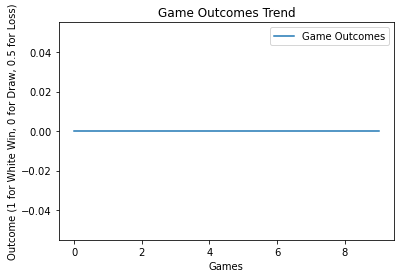

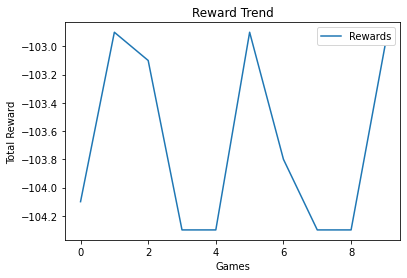

In [11]:
# Path to Stockfish engine
stockfish_path = "/Users/benitorusconi/Documents/CDS/05_HS23/Reinforcement Learning (cds-117)/engine/stockfish"
pgn_file_path = '/Users/benitorusconi/Downloads/Carlsen_plus-stockfish.pgn'
stockfish = Stockfish(path=stockfish_path)

#stockfish.set_skill_level(1)
# Hyperparameters
learning_rate = 0.01
discount_factor = 0.99
exploration_prob = 0.2

# Neural Network Architecture
state_space_size = (8, 8, 12)  # 8x8 board with 12 channels (one for each piece type and color)
action_space_size = 4096



# Initialize a deque for experience replay
experience_replay_buffer = deque(maxlen=1000)

# Neural Network Model alpha zero


# Input layer
input_layer = Input(shape=state_space_size)

# Contracting path
# Convolutional layers
conv1 = Conv2D(128, (3, 3), activation='relu', padding='same')(input_layer)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv1)
flatten_layer = Flatten()(conv2)
dense1 = Dense(128, activation='relu')(flatten_layer)
dense2 = Dense(64, activation='relu')(dense1)
output_layer = Dense(action_space_size, activation='softmax')(dense2)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.1), loss=['categorical_crossentropy'], metrics=['accuracy'])




# Pre-training the model on PGN games
def pretrain_model(model, pgn_data):
    print("Pre-training on PGN data...")
    total_pgn_games = len(pgn_data)

    # Use tqdm to create a progress bar
    for game_idx, (input_array, output_array) in enumerate(tqdm(pgn_data, desc="Processing", ncols=100), start=1):
        # Reshape input for the model, if necessary
        input_array = input_array.reshape((1,) + input_array.shape)
        output_array = output_array.reshape((1,) + output_array.shape)
        model.train_on_batch(input_array, output_array)

    # Save the pretrained model
    model.save("carlse_st")  # Change the file name as needed
    print("Pretrained model saved.")




def normalize_input(board):
    board_array = np.array(board_to_input_array(board), dtype=np.float16)
    board_array /= 12.0  # Assuming the maximum piece type value is 12
    return board_array



def update_q_table(state, action, reward, next_state):
    state_index = state_to_index(state)
    next_state_index = state_to_index(next_state)
    action_index = list(state.legal_moves).index(action)
    


    # Combine the rewards with weights (you can adjust the weights as needed)
    #total_reward = reward + 0.01 * piece_coordination_reward_value
    total_reward = reward

    # Store the experience in the replay buffer
    experience_replay_buffer.append((state_index, action_index, total_reward, next_state_index))

    # Sample a batch from the replay buffer for training
    batch_size = min(len(experience_replay_buffer), 8)
    if batch_size > 0:
        batch = np.array(random.sample(experience_replay_buffer, batch_size))
        states = np.array([board_to_input_array(chess.Board(fen=chess.STARTING_FEN)) for _ in batch[:, 0]])
        next_states = np.array([board_to_input_array(chess.Board(fen=chess.STARTING_FEN)) for _ in batch[:, 3]])
        q_values = model.predict(states)
        next_q_values = model.predict(next_states)
        
        for i in range(batch_size):
            action_idx = int(batch[i, 1])  # Cast to integer
            q_values[i, action_idx] += learning_rate * (
                batch[i, 2] + discount_factor * np.max(next_q_values[i]) - q_values[i, action_idx]
            )
        
        # Train the model on the batch
        model.train_on_batch(states, q_values)


def display_chess_board(board):
    return display(HTML(chess.svg.board(board=board, size=200)))

def play_game():
    
    
    board = chess.Board()

    
    game_states = []
    total_reward = 0  # Initialize total_reward

    while not board.is_game_over():
        state = board.copy()
        game_states.append(state.copy())

        rl_move = choose_action(board,model)
        if rl_move in board.legal_moves:
            board.push(rl_move)
        else:
            print("Invalid move. Try again.")
            continue

        reward = 0

        if board.is_game_over():
            break

        stockfish.set_fen_position(board.fen())
        stockfish_move_uci = stockfish.get_best_move()
        stockfish_move = chess.Move.from_uci(stockfish_move_uci)
        next_state = board.copy()
        board.push(stockfish_move)

        if next_state.is_check():
            reward = 0.1

        if board.result() == "1-0":
            reward += 100  # Win
        elif board.result() == "0-1":
            move_number = len(game_states)
            reward -=100 # Loss 
        elif board.result() == "1/2-1/2":
            reward -= 100  # Draw
            
            
        #capture reward
        
        if board.is_capture(rl_move):
            reward += piece_value(board.piece_at(rl_move.to_square))
            
        if board.is_capture(stockfish_move):
            reward -= piece_value(board.piece_at(stockfish_move.to_square))
            
            




        update_q_table(state, rl_move, reward, next_state)

        # Accumulate the reward
        total_reward += reward



    game_states.append(board.copy())
    return game_states, board.result(), total_reward  # Return total_reward




def piece_value(piece):
    if piece is None:
        return 0
    elif piece.piece_type == chess.PAWN:
        return 0.1
    elif piece.piece_type == chess.KNIGHT:
        return 0.3
    elif piece.piece_type == chess.BISHOP:
        return 0.3
    elif piece.piece_type == chess.ROOK:
        return 0.5
    elif piece.piece_type == chess.QUEEN:
        return 0.9
    elif piece.piece_type == chess.KING:
        return 0





#pgn_data = load_pgn_data(pgn_file_path)

# Pre-train the model
#pretrain_model(model, pgn_data)

# Load the pretrained model
model = load_model("/Users/benitorusconi/Documents/CDS/05_HS23/Reinforcement Learning (cds-117)/chess_bot/benito/carlsen_stock_trained.h5")  # Provide the correct file path

# Use the pretrained_model for inference or further training




log_dir = "logs/"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
num_games = 10
total_rewards = []
results = {"white_wins": 0, "black_wins": 0, "draws": 0}
outcomes = []


reward_trend = []

for episode in tqdm(range(num_games), desc="Training"):
    exploration_prob *= 0.99  # Decay exploration probability
    print("Game:", episode)
    game_states, result, total_reward = play_game()

    # Append the total reward to the reward trend list
    reward_trend.append(total_reward)

    # Update results based on the game outcome
    if result == "1-0":
        results["white_wins"] += 1
        outcomes.append(1)
    elif result == "0-1":
        results["black_wins"] += 1
        outcomes.append(0)
    elif result == "1/2-1/2":
        results["draws"] += 1
        outcomes.append(0.5)  # Fix here: Append 0.5 for draws

    total_rewards.append(total_reward)
    
    # Display the total reward for each game
    print("Total Reward for Game {}: {}".format(episode, total_reward))
    print("Game Outcome:", result)
    #game length
    print("Game Length:", len(game_states))

# Display statistics
average_reward = sum(total_rewards) / num_games
print("Average Total Reward:", average_reward)

# Extract the FEN of the final position
final_position_fen = game_states[-1].fen()
print("Final Position FEN:", final_position_fen)

# Display the last game
for state in game_states:
    display_chess_board(state)

# Display results
print("\nResults Summary:")
print("White Wins:", results["white_wins"])
print("Black Wins:", results["black_wins"])
print("Draws:", results["draws"])

# Plot trend lines
plt.plot(outcomes, label="Game Outcomes")
plt.xlabel("Games")
plt.ylabel("Outcome (1 for White Win, 0 for Draw, 0.5 for Loss)")
plt.legend()
plt.title("Game Outcomes Trend")

# Plot rewards
plt.figure()
plt.plot(reward_trend, label="Rewards")
plt.xlabel("Games")
plt.ylabel("Total Reward")
plt.legend()
plt.title("Reward Trend")

plt.show()

# Save the model

#model.save("carlsen_stock_trained.h5")  # Change the file name as needed